Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


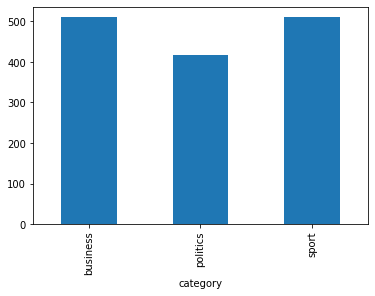

In [1]:
!pip install transformers
!pip install jax
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

bert_checkpoint = 'bert-base-cased'
roberta_checkpoint = 'roberta-base'

checkpoint = bert_checkpoint

datapath = "bbc_train.csv"
df = pd.read_csv(datapath)
df.groupby(['category']).size().plot.bar()
tokenizer = BertTokenizer.from_pretrained(checkpoint)

labels = {'business':0,
          'sport':1,
          'politics':2
          # 'entertainment':3,
          # 'tech':4,
          }

In [2]:
df.head()

,text,category
0,Quarterly profits at US media giant TimeWarner...,business
1,The dollar has hit its highest level against t...,business
2,The owners of embattled Russian oil giant Yuko...,business
3,British Airways has blamed high fuel prices fo...,business
4,Shares in UK drinks and food firm Allied Domec...,business


In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [4]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from transformers import BertTokenizer, BertModel, AutoModelForSequenceClassification
from torch import nn
#import evaluate as metric_evaluate
import torch.nn.functional as F
from torchmetrics.functional import auc, precision_recall
from torchmetrics.classification import MulticlassF1Score, MulticlassROC

class TextClassifier(nn.Module): 

    def __init__(self, checkpoint, num_of_classes, dropout=0.5):

        super(TextClassifier, self).__init__()

        self.bert = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                                     num_labels=num_of_classes)
        self.num_of_labels = num_of_classes

    def forward(self, input_id, mask, labels):

        pooled_output = self.bert(input_ids= input_id, attention_mask=mask,
                                  labels=labels, return_dict=True)

        return pooled_output

def train(model, train_data, val_data, learning_rate, epochs, train_batch_size, val_batch_size):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=val_batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            total_auc_train = 0
            total_recall_train = 0
            total_precision_train = 0
            total_f1_train = 0
            # total_fpr_train = 0
            # total_tpr_train = 0
            # total_thresholds_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask, train_label)
                #print(f"\n output:{output} \n")
                
                probabilities = F.softmax(output.logits, dim=1)
                #print(f"probabilities: {probabilities}")

                loss = criterion(probabilities, train_label.long())
                #print(f"loss: {loss}")

                (predictions, predictions_indicies) = torch.max(probabilities,dim=1)

                # print(f"predictions: {predictions}")
                # print(f"train_label: {train_label}")

                metric_auc = auc(predictions, train_label, reorder=True)
                # print(f"metric_auc: {metric_auc}")

                metric_precision_recall = precision_recall(preds=probabilities, target=train_label,num_classes=model.num_of_labels)
                precision, recall = metric_precision_recall[0], metric_precision_recall[1]
                # print(f"\nprecision: {precision}\n")
                # print(f"recall: {recall}\n")

                metric_f1 = MulticlassF1Score(num_classes=model.num_of_labels).to(device)
                f1 = metric_f1(predictions, train_label)
                #print(f"f1: {f1}\n")

                # metric_roc = MulticlassROC(num_classes=5)
                # fpr_tpr_thresholds_tuple = metric_roc(probabilities, train_label)
                # print(f"fpr: {fpr_tpr_thresholds_tuple[0]}\n")
                # print(f"tpr: {fpr_tpr_thresholds_tuple[1]}\n")
                # print(f"thresholds: {fpr_tpr_thresholds_tuple[2]}\n")

                total_loss_train += loss
              
                acc = (predictions_indicies == train_label).sum().item()
                total_acc_train += acc

                total_auc_train += metric_auc
                total_recall_train += recall
                total_precision_train += precision
                total_f1_train += f1
                # total_fpr_train += fpr_tpr_thresholds_tuple[0]
                # total_tpr_train += fpr_tpr_thresholds_tuple[1]
                #total_thresholds_train += fpr_tpr_thresholds_tuple[3]

                model.zero_grad()
                loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            total_recall_val = 0
            total_precision_val = 0
            total_f1_val = 0
            total_auc_val = 0
            # total_fpr_val = 0
            # total_tpr_val = 0
            # total_thresholds_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask, val_label)
                    #batch_loss = criterion(output, val_label.long())
                    #total_loss_val += batch_loss.item()
                    
                    probabilities = F.softmax(output.logits, dim=1)

                    loss = criterion(probabilities, val_label.long())
                    #print(f"loss: {loss}")

                    (predictions, predictions_indicies) = torch.max(probabilities,dim=1)

                    # print(f"predictions: {predictions}")
                    # print(f"train_label: {train_label}")

                    metric_auc = auc(predictions, val_label, reorder=True)
                    # print(f"metric_auc: {metric_auc}")

                    metric_precision_recall = precision_recall(preds=probabilities, target=val_label,num_classes=model.num_of_labels)
                    precision, recall = metric_precision_recall[0], metric_precision_recall[1]
                    # print(f"\nprecision: {precision}\n")
                    # print(f"recall: {recall}\n")

                    metric_f1 = MulticlassF1Score(num_classes=model.num_of_labels).to(device)
                    f1 = metric_f1(predictions, val_label)
                    #print(f"f1: {f1}\n")

                    # metric_roc = MulticlassROC(num_classes=5)
                    # fpr_tpr_thresholds_tuple = metric_roc(probabilities, train_label)
                    # print(f"fpr: {fpr_tpr_thresholds_tuple[0]}\n")
                    # print(f"tpr: {fpr_tpr_thresholds_tuple[1]}\n")
                    # print(f"thresholds: {fpr_tpr_thresholds_tuple[2]}\n")

                    total_loss_val += loss
                  
                    acc = (predictions_indicies == val_label).sum().item()
                    total_acc_val += acc

                    total_auc_val += metric_auc
                    total_recall_val += recall
                    total_precision_val += precision
                    total_f1_val += f1

            print(f"Epochs: {epoch_num + 1} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Recall: {total_recall_train / len(train_data): .3f} | Train Precision: {total_precision_train / len(train_data): .3f} | Train F1-Score: {total_f1_train / len(train_data): .3f} | Train AUC: {total_auc_train/ len(train_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | TraValin Recall: {total_recall_val / len(val_data): .3f} | Val Precision: {total_precision_val / len(val_data): .3f} | Val F1-Score: {total_f1_val / len(val_data): .3f} | Val AUC: {total_auc_val/ len(val_data): .3f}")
                  
def evaluate(model, test_data, test_batch_size):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=test_batch_size)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    #total_loss_test = 0
    total_auc_test = 0
    total_recall_test = 0
    total_precision_test = 0
    total_f1_test = 0

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask, test_label)
              #batch_loss = criterion(output, val_label.long())
              #total_loss_val += batch_loss.item()
              
              probabilities = F.softmax(output.logits, dim=1)

              #loss = criterion(probabilities, test_label.long())
              #print(f"loss: {loss}")

              (predictions, predictions_indicies) = torch.max(probabilities,dim=1)

              # print(f"predictions: {predictions}")
              # print(f"train_label: {train_label}")

              metric_auc = auc(predictions, test_label, reorder=True)
              # print(f"metric_auc: {metric_auc}")

              metric_precision_recall = precision_recall(preds=probabilities, target=test_label,num_classes=model.num_of_labels)
              precision, recall = metric_precision_recall[0], metric_precision_recall[1]
              # print(f"\nprecision: {precision}\n")
              # print(f"recall: {recall}\n")

              metric_f1 = MulticlassF1Score(num_classes=model.num_of_labels).to(device)
              f1 = metric_f1(predictions, test_label)
              #print(f"f1: {f1}\n")

              # metric_roc = MulticlassROC(num_classes=5)
              # fpr_tpr_thresholds_tuple = metric_roc(probabilities, train_label)
              # print(f"fpr: {fpr_tpr_thresholds_tuple[0]}\n")
              # print(f"tpr: {fpr_tpr_thresholds_tuple[1]}\n")
              # print(f"thresholds: {fpr_tpr_thresholds_tuple[2]}\n")

              #total_loss_val += loss

              acc = (predictions_indicies == test_label).sum().item()
              total_acc_test += acc

              total_auc_test += metric_auc
              total_recall_test += recall
              total_precision_test += precision
              total_f1_test += f1
  
    print(f"Test Accuracy: {total_acc_test / len(test_data): .3f} | Test Recall: {total_recall_test / len(test_data): .3f} | Test Precision: {total_precision_test / len(test_data): .3f} | Test F1-Score: {total_f1_test / len(test_data): .3f} | Test AUC: {total_auc_test/ len(test_data): .3f}")



In [6]:
np.random.seed(42)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1150 144 144


In [7]:
num_of_classes=3
model = TextClassifier(checkpoint, num_of_classes=num_of_classes)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [8]:
EPOCHS = 1
LR = 1e-6
train_batch_size = 16
val_batch_size = 12

train(model, df_train, df_val, LR, EPOCHS, train_batch_size, val_batch_size)

  1%|▏         | 1/72 [02:21<2:47:19, 141.40s/it]


KeyboardInterrupt: ignored

In [9]:
test_batch_size = 12
evaluate(model, df_test, test_batch_size)

KeyboardInterrupt: ignored